In [1]:
import os

In [2]:
original_folder_path = '/kaggle/input/rose-leaf-new-dataset'

In [3]:
# Iterate over subfolders in the folder
for subfolder in os.listdir(original_folder_path):
    subfolder_path = os.path.join(original_folder_path, subfolder)

    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Count the number of files in the subfolder
        file_count = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])

        # Display subfolder name and file count
        print(f"Subfolder: {subfolder}, Files: {file_count}")

Subfolder: Magnesium Deficiency, Files: 110
Subfolder: Healthy Leaf, Files: 110
Subfolder: Phosphorus Deficiency, Files: 110
Subfolder: Heat Stress, Files: 110
Subfolder: Iron Deficiency, Files: 110


In [4]:
! pip install python_splitter
import python_splitter
python_splitter.split_from_folder(original_folder_path, train=0.7, val=0.2, test=0.1)

✅Checking SOURCE directory...
0.7 0.2 0.1
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [5]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
train_dir = "/kaggle/working/Train_Test_Folder/train"
test_dir = "/kaggle/working/Train_Test_Folder/test"
val_dir = "/kaggle/working/Train_Test_Folder/val"

In [9]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator()

In [10]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=32, 
                                            shuffle=True, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode='categorical',
                                                target_size=(224, 224))
test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=32, 
                                            shuffle=False, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

Found 385 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 115 images belonging to 5 classes.


In [11]:
class_indices = train.class_indices

# class_indices is a dictionary with class names as keys and their corresponding numerical labels as values
# Example: {'class_name_1': 0, 'class_name_2': 1, 'class_name_3': 2, 'class_name_4': 3}

# To reverse the dictionary, you can create a mapping from numerical labels to class names
class_labels = {v: k for k, v in class_indices.items()}

# Now you can access class names using numerical labels
print(class_labels[0])  # This will give you the corresponding class name for label 0
print(class_labels[1])  # This will give you the corresponding class name for label 1
print(class_labels[2])  # This will give you the corresponding class name for label 2
print(class_labels[3])  # This will give you the corresponding class name for label 3
print(class_labels[4])  # This will give you the corresponding class name for label 3

Healthy Leaf
Heat Stress
Iron Deficiency
Magnesium Deficiency
Phosphorus Deficiency


In [12]:
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax

In [13]:
model_name = "ResNet50"
class_names = {
    0: 'Healthy Leaf', 
    1: 'Heat Stress', 
    2: 'Iron Deficiency', 
    3: 'Magnesium Deficiency', 
    4: 'Phosphorus Deficiency'
}  # Add all your class names

In [14]:
# Define the input shape
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

# Load the pre-trained DenseNet201 model
ResNet50_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Freeze the layers in the base model
for layer in ResNet50_model.layers:
    layer.trainable = False

# Add global average pooling layer
x = GlobalAveragePooling2D()(ResNet50_model.output)

# Batch Normalization
x = BatchNormalization()(x)

# Add a fully connected layer with 512 units
x = Dense(1024, activation='relu')(x)

# Add a dropout layer
# x = Dropout(0.2)(x)

# Add the output layer with 8 units for classification (adjust as needed)
output = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=input_tensor, outputs=output)

# Print model summary
# model.summary()

94765736/94765736 [==============================] - 1s 0us/step


In [15]:
from tensorflow.keras.utils import plot_model

# Assuming you already have a model defined and compiled

# Generate a simplified model summary
model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
model_summary = "\n".join(model_summary)

summary = model_name + "model_summary.txt"

# Save the model summary as text
with open(summary, "w") as text_file:
    text_file.write(model_summary)

# Plot the model architecture and save it as an image
# plot_model(model, to_file="densenet201_model_summary.png", show_shapes=True, show_layer_names=False)

In [16]:
layers = model.layers
print(f"The model has {len(layers)} layers")

The model has 179 layers


In [17]:
print(f"The input shape {model.input}")
print(f"The output shape {model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")


In [18]:
# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(train, validation_data=validation, steps_per_epoch=len(train), epochs=20)

Epoch 1/20
13/13 [==============================] - 39s 2s/step - loss: 0.6814 - accuracy: 0.7662 - val_loss: 0.6884 - val_accuracy: 0.8000
Epoch 2/20
13/13 [==============================] - 32s 3s/step - loss: 0.0185 - accuracy: 0.9922 - val_loss: 0.4139 - val_accuracy: 0.8000
Epoch 3/20
13/13 [==============================] - 30s 2s/step - loss: 0.0138 - accuracy: 0.9948 - val_loss: 0.2896 - val_accuracy: 0.8600
Epoch 4/20
13/13 [==============================] - 30s 3s/step - loss: 0.0101 - accuracy: 0.9974 - val_loss: 0.2341 - val_accuracy: 0.9000
Epoch 5/20
13/13 [==============================] - 31s 2s/step - loss: 0.0058 - accuracy: 0.9974 - val_loss: 0.2037 - val_accuracy: 0.9200
Epoch 6/20
13/13 [==============================] - 31s 2s/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.1930 - val_accuracy: 0.9400
Epoch 7/20
13/13 [==============================] - 32s 2s/step - loss: 0.0057 - accuracy: 0.9974 - val_loss: 0.1862 - val_accuracy: 0.9400
Epoch 8/20
13/13 [==

In [20]:
import pandas as pd

training_history = model_name + "training_history.csv"

history_df = pd.DataFrame(history.history)
history_df.to_csv(model_name, index=False)

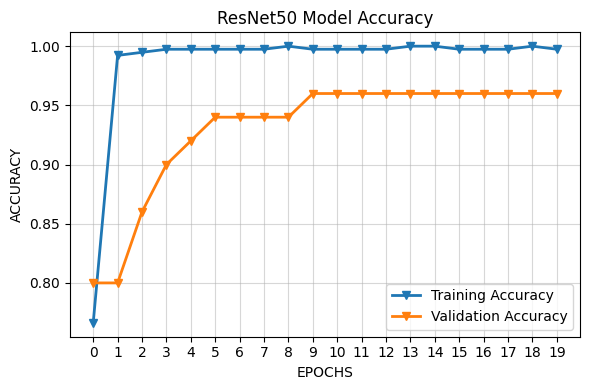

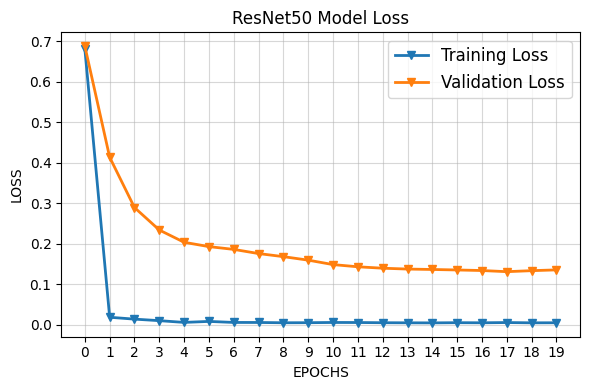

In [61]:
# !pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# --------------Model Accuracy-----------#

# Plot training accuracy with a solid blue line and validation accuracy with a solid red line
plt.plot(history.history['accuracy'], label='Training Accuracy',  linewidth=2, marker='v')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',  linewidth=2, marker='v')

# Add grid lines
plt.grid(True, linestyle='-', alpha=0.5)

# Set the title, labels, and legend
plt.title('Model Accuracy', fontsize=12)
plt.xlabel('EPOCHS', fontsize=10)
plt.ylabel('ACCURACY', fontsize=10)
plt.legend(fontsize=10 )

# Customize the x and y axis tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend with a shadow and a legend title
accuracy_title = model_name + " Model Accuracy"
plt.legend(fontsize=10, loc='lower right')
plt.gca().set_title(accuracy_title, fontsize=12)

# Customize the X-axis tick locator and formatter
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer X-axis tick locator
ax.set_xticks(np.arange(0, len(history.history['accuracy'])))  # Set ticks at all integer positions

# Adjust figure size (optional)
fig = plt.gcf()
fig.set_size_inches(6, 4)

# Save the figure in high resolution (e.g., 300 DPI) as a PNG file
plot_title = model_name + " accuracy_plot.png"
fig.savefig(plot_title, dpi=1000, bbox_inches='tight')

# Show or save the plot
plt.tight_layout()
plt.show()

# ------------------------- Model Loss ---------------#

# Assuming you have already defined the 'history' variable containing accuracy data
# fig1 = plt.gcf()

# Plot training accuracy with a solid blue line and validation accuracy with a solid red line
plt.plot(history.history['loss'], label='Training Loss',  linewidth=2, marker='v')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='v')

# Add grid lines
plt.grid(True, linestyle='-', alpha=0.5)

# Set the title, labels, and legend
plt.title('Model Loss', fontsize=12)
plt.xlabel('EPOCHS', fontsize=10)
plt.ylabel('LOSS', fontsize=10)
plt.legend(fontsize=10)

# Customize the x and y axis tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend with a shadow and a legend title
plt.legend(fontsize=12, loc='upper right')
model_loss_title = model_name + " Model Loss"
plt.gca().set_title(model_loss_title, fontsize=12)

# Customize the X-axis tick locator and formatter
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set integer X-axis tick locator

ax.set_xticks(np.arange(0, len(history.history['loss'])))  # Set ticks at all integer positions

# Adjust figure size (optional)
fig = plt.gcf()
fig.set_size_inches(6, 4)

# Save the figure in high resolution (e.g., 300 DPI) as a PNG file
loss_plot = model_name + "_loss_plot.png"
fig.savefig(loss_plot, dpi=1000, bbox_inches='tight')

# Show or save the plot
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

evaluation1 = model.evaluate(train)
train_title = model_name + " Train Accuracy"
print(f"{train_title}: {evaluation1[1] * 100:.2f}%")

evaluation2 = model.evaluate(validation)
val_title = model_name + " Validation Accuracy"
print(f"{val_title}: {evaluation2[1] * 100:.2f}%")

test_title = model_name + " Test Accuracy"
evaluation3 = model.evaluate(test)
print(f"{test_title}: {evaluation3[1] * 100:.2f}%")

13/13 [==============================] - 28s 2s/step - loss: 7.9532e-04 - accuracy: 1.0000
ResNet50 Train Accuracy: 100.00%
2/2 [==============================] - 3s 1s/step - loss: 0.1355 - accuracy: 0.9600
ResNet50 Validation Accuracy: 96.00%
4/4 [==============================] - 9s 2s/step - loss: 0.1148 - accuracy: 0.9652
ResNet50 Test Accuracy: 96.52%


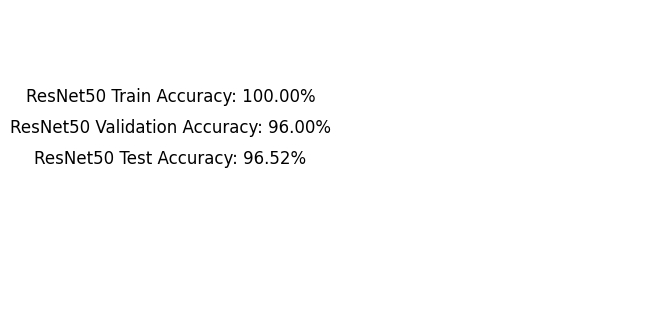

In [23]:
# Your evaluation code here
train_accuracy = evaluation1[1] * 100
validation_accuracy = evaluation2[1] * 100
test_accuracy = evaluation3[1] * 100

# Create a text image
plt.figure(figsize=(6, 4))
plt.text(0.0, 0.7, f"{train_title}: {train_accuracy:.2f}%", fontsize=12, ha='center')
plt.text(0.0, 0.6, f"{val_title}: {validation_accuracy:.2f}%", fontsize=12, ha='center')
plt.text(0.0, 0.5, f"{test_title}: {test_accuracy:.2f}%", fontsize=12, ha='center')
plt.axis('off')

# Save the image
evaluation_results = model_name + "_evaluation_results.png"
plt.savefig(evaluation_results, format='png', bbox_inches='tight', dpi=1000)

In [24]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

predicted_vals = model.predict(test, steps=len(test))
predicted_labels = np.argmax(predicted_vals, axis=1)

# Convert class indices to class names
predicted_class_names = [class_names[i] for i in predicted_labels]

# Create a classification report using class names
report = classification_report([class_names[i] for i in test.classes], predicted_class_names, output_dict=True)

# Display the classification report as a DataFrame
df = pd.DataFrame(report)
classification_report = model_name + " Classification Report:"
print( classification_report)
print('\n\n')
print(df)

4/4 [==============================] - 10s 2s/step
ResNet50 Classification Report:



           Healthy Leaf  Heat Stress  Iron Deficiency  Magnesium Deficiency  \
precision           1.0     1.000000              1.0              0.954545   
recall              1.0     0.956522              1.0              0.913043   
f1-score            1.0     0.977778              1.0              0.933333   
support            23.0    23.000000             23.0             23.000000   

           Phosphorus Deficiency  accuracy   macro avg  weighted avg  
precision               0.880000  0.965217    0.966909      0.966909  
recall                  0.956522  0.965217    0.965217      0.965217  
f1-score                0.916667  0.965217    0.965556      0.965556  
support                23.000000  0.965217  115.000000    115.000000  


4/4 [==============================] - 9s 2s/step


<Figure size 800x600 with 0 Axes>

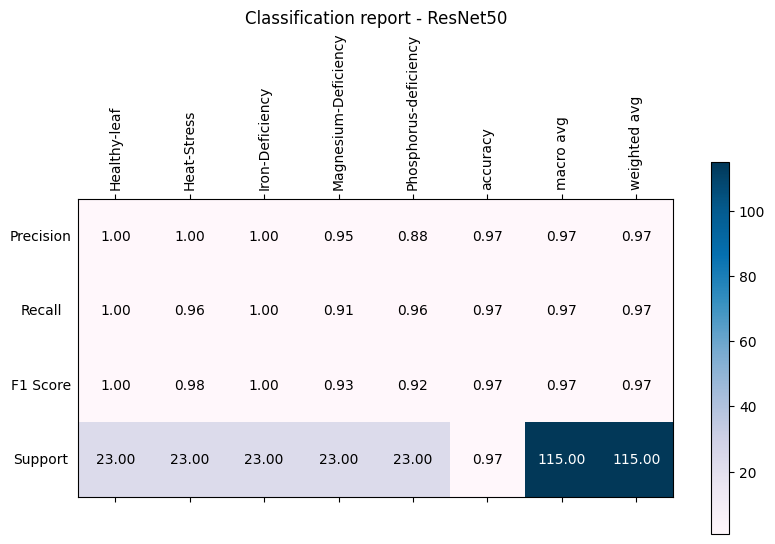

In [84]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

predicted_vals = model.predict(test, steps=len(test))
predicted_labels = np.argmax(predicted_vals, axis=1)

# Convert class indices to class names
predicted_class_names = [class_names[i] for i in predicted_labels]

# Create a classification report using class names
report = classification_report([class_names[i] for i in test.classes], predicted_class_names, output_dict=True)
report_df = pd.DataFrame(report)

# Create a heatmap from the DataFrame
plt.figure(figsize=(8, 6))
cax = plt.matshow(report_df, cmap='PuBu', interpolation='nearest')
plt.title( classification_report)

# Display the values on the heatmap with annotations
for i in range(report_df.shape[0]):
    for j in range(report_df.shape[1]):
        # Check if the value is in the deep purple area
        text_color = 'k' if 0.6 <= report_df.iloc[i, j] <= 23.0 else 'w'
        plt.text(j, i, f"{report_df.iloc[i, j]:.2f}", va='center', ha='center', color=text_color)

# Add labels for precision, recall, and F1 Score
plt.text(-1, 0, 'Precision', va='center', ha='center', color='k')
plt.text(-1, 1, 'Recall', va='center', ha='center', color='k')
plt.text(-1, 2, 'F1 Score', va='center', ha='center', color='k')
plt.text(-1, 3, 'Support', va='center', ha='center', color='k')

plt.colorbar(cax)
plt.xticks(range(len(report_df.columns)), report_df.columns, rotation=90)
plt.yticks([])

classification_report_name = "Classification report - " + model_name
plt.title(classification_report_name)

# Save the image
classification_report_png = model_name + "_classification_report.png"
plt.savefig(classification_report_png , format='png', bbox_inches='tight', dpi=1000)

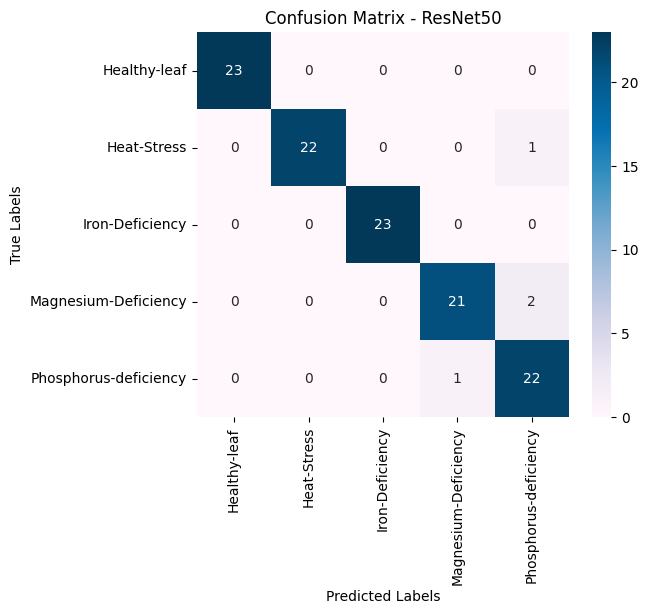

In [81]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your code to compute the confusion matrix and predicted_labels
# ...


# Convert class indices to class names for both true and predicted labels
true_class_names = [class_names[i] for i in test.classes]
predicted_class_names = [class_names[i] for i in predicted_labels]

# Generate the confusion matrix
resnet_confusion = confusion_matrix(true_class_names, predicted_class_names)

# Plot the confusion matrix as a heatmap with class names
plt.figure(figsize=(6, 5))
sns.heatmap(resnet_confusion, annot=True, fmt="d", cmap="PuBu", xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
confution_mat_title = "Confusion Matrix - " + model_name
plt.title(confution_mat_title)


# Save the confusion matrix as an image (e.g., in PNG format)
confusion_mat_png = model_name + "_confusion_matrix.png"
plt.savefig(confusion_mat_png, dpi=1000, bbox_inches='tight')

# Display the plot
plt.show()